In [64]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Load the training data
train_data_path = '/data/challenge2_files/fulvestrantTrain.tsv'
train_df = pd.read_csv(train_data_path, sep='\t')

# Assuming 'Fulvestrant_response' is the target variable
target_variable = 'Fulvestrant_response'

# Separate features and target variable
X = train_df.drop(target_variable, axis=1)
y = train_df[target_variable]

# Encode categorical variables if needed
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column])

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X, y)

# Create a DataFrame to display feature names and their mutual information scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Info_Score': mutual_info_scores})
feature_scores = feature_scores.sort_values(by='Mutual_Info_Score', ascending=False)

# Print features with mutual information score greater than 0.2
selected_features = feature_scores[feature_scores['Mutual_Info_Score'] > 0.2]['Feature'].tolist()
print("Selected Features with Mutual Information Score > 0.2:", selected_features)


Selected Features with Mutual Information Score > 0.2: ['rna_LOC100505938', 'rna_ZNF296', 'rna_LINC00493', 'rna_RFX5', 'rna_DCAF12L1', 'rna_DNAJA2', 'rna_RNF157', 'rna_CASP6', 'rna_ITGA1', 'rna_ZHX1-C8orf76', 'rna_TAF13', 'rna_MED18', 'rna_DPH7', 'rna_ABT1', 'rna_PPCS', 'rna_FAM127A', 'rna_PDE6B', 'rna_DCP1B', 'rna_SLC2A1', 'rna_TARSL2', 'rna_COQ4', 'mut_AKAP13', 'rna_MRPS34', 'rna_FBXO33', 'rna_JAGN1', 'rna_ZNF548', 'rna_KCNQ4', 'rna_MYO10', 'rna_AMDHD2', 'rna_LINC00173']


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Load the training and test datasets
train_data_path = '/data/challenge2_files/fulvestrantTrain.tsv'
test_data_path = '/data/testData.tsv'
train_df = pd.read_csv(train_data_path, sep='\t')
test_df = pd.read_csv(test_data_path, sep='\t')

# Columns of interest from decision tree
# Columns to include for modeling
columns_of_interest = ['rna_LOC100505938', 'rna_ZNF296', 'rna_LINC00493', 'rna_RFX5', 'rna_DCAF12L1', 'rna_DNAJA2', 'rna_RNF157', 'rna_CASP6', 'rna_ITGA1', 'rna_ZHX1-C8orf76', 'rna_TAF13', 'rna_MED18', 'rna_DPH7', 'rna_ABT1', 'rna_PPCS', 'rna_FAM127A', 'rna_PDE6B', 'rna_DCP1B', 'rna_SLC2A1', 'rna_TARSL2', 'rna_COQ4', 'mut_AKAP13', 'rna_MRPS34', 'rna_FBXO33', 'rna_JAGN1', 'rna_ZNF548', 'rna_KCNQ4', 'rna_MYO10', 'rna_AMDHD2', 'rna_LINC00173']
target_column = 'Fulvestrant_response'

# Ensure both dataframes have the same columns
common_columns = set(train_df.columns) & set(test_df.columns)
common_columns.discard(target_column)

# Keep only the common columns in both datasets
columns_of_interest = list(set(columns_of_interest).intersection(common_columns))

# Keep only the specified columns in both datasets
train_df = train_df[[target_column] + columns_of_interest]
test_df = test_df[columns_of_interest]

# Assuming 'Mitomycin-Fulvestrant_response' is the target column
features = [col for col in train_df.columns if col != target_column]

# Identify categorical columns
categorical_columns = train_df[features].select_dtypes(include=['object']).columns.tolist()

# Apply Box-Cox transformation to specified columns
power_transformer = PowerTransformer()
train_df[columns_of_interest[1:]] = power_transformer.fit_transform(train_df[columns_of_interest[1:]])
test_df[columns_of_interest[1:]] = power_transformer.transform(test_df[columns_of_interest[1:]])

# One-hot encode categorical columns using ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

# Apply one-hot encoding to training and test data
X_train_encoded = encoder.fit_transform(train_df[features])
X_test_encoded = encoder.transform(test_df)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_encoded)
X_test_std = scaler.transform(X_test_encoded)

# Upsample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_std, train_df[target_column])

# Feature selection using SelectKBest
k_best = 10  # Adjust the value based on your data
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Build a stack of Adaboost and Decision Tree classifiers
base_classifier = DecisionTreeClassifier(max_depth=5)  # Adjust max_depth as needed
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=100, random_state=42)

# Combine the preprocessing and model training into a pipeline
from sklearn.pipeline import Pipeline
model = Pipeline([
    ('feature_selection', selector),
    ('adaboost_classifier', adaboost_classifier)
])

# Perform cross-validation and get mean accuracy
cv_accuracy = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
mean_accuracy = cv_accuracy.mean()

print(f"Mean Cross-Validated Accuracy: {mean_accuracy}")

# Train the model on the entire training data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = model.predict(X_test_std)

# Display the predictions and the updated test_df with row numbers
test_df['Fulvestrant_response'] = y_test_pred
result_df = test_df[['Fulvestrant_response']]
print(result_df)


Mean Cross-Validated Accuracy: 0.95
                 Fulvestrant_response
BrainCNS_VFF746                     0
Bowel_KI64                          0
Bowel_QEVT62                        0
Lung_TXY395                         0
Lung_JIL5                           1
Blood_CB485                         0
Skin_SFL7                           0
Skin_VAK5                           0
Ovary_XT38                          0


AUC Score: 0.75


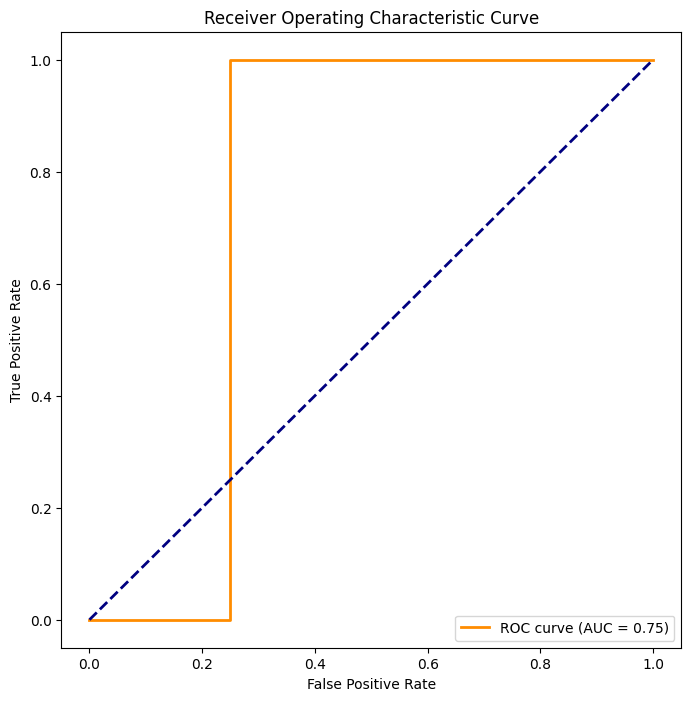

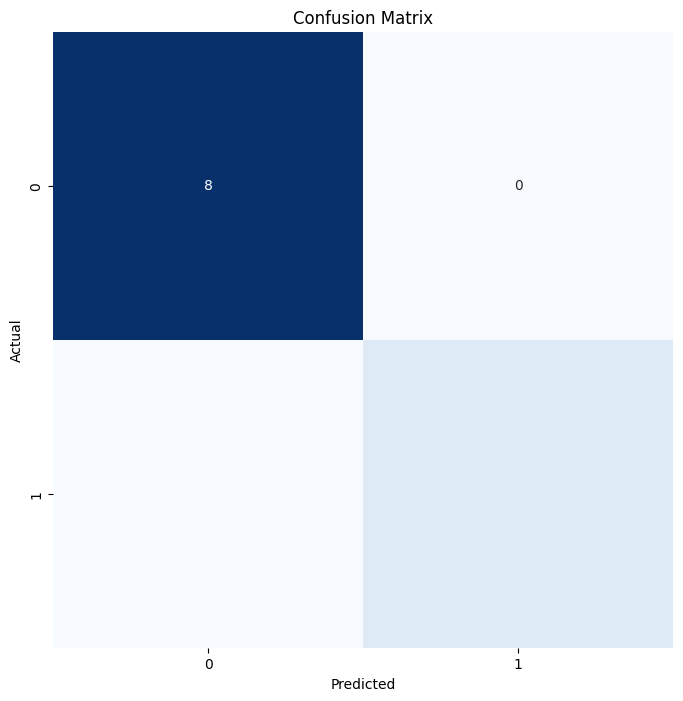

In [69]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate AUC
y_test_true = test_df[target_column]  # Assuming 'Fulvestrant_response' is the target column

auc_score = roc_auc_score(y_test_true, y_test_pred_prob)

print(f"AUC Score: {auc_score}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_true, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [107]:
import pandas as pd

# Values provided
custom_values = ['Fulvestrant_response.ipynb', 'sklearn_adaboost', 95, 30, 'Mutual Index score', "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'",
                 "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'", "'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7'"]

# Create a DataFrame with custom values
custom_df = pd.DataFrame(custom_values, index=['Filename', 'Algorithm used', 'Training accuracy', 'Number of Features', 'Feature evaluation method', 'Overall key feature',
                                               'Breast key feature', 'BrainCNS key feature', 'Bowel key feature', 'Blood key feature', 'Skin key feature',
                                               'Lung key feature', 'Ovary key feature', 'Prostate key feature', 'Kidney key feature'], columns=['Fulvestrant_response'])

# Save the DataFrame to the specified path
custom_df.to_csv('/results/Code_sharks_model_info.csv', index=True, header = True)

# Display the created DataFrame
print(custom_df)


                                                        Fulvestrant_response
Filename                                          Fulvestrant_response.ipynb
Algorithm used                                              sklearn_adaboost
Training accuracy                                                         95
Number of Features                                                        30
Feature evaluation method                                 Mutual Index score
Overall key feature        'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
Breast key feature         'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
BrainCNS key feature       'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
Bowel key feature          'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
Blood key feature          'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
Skin key feature           'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...
Lung key feature           'rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296',...

In [70]:
len(selected_features)

30

In [93]:


# Feature selection using SelectKBest
k_best = 10  # Adjust the value based on your data
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Print the names of the selected features
selected_feature_names = [features[i] for i, selected in enumerate(selector.get_support()) if selected]
print("Selected Features:", selected_feature_names)




Selected Features: ['rna_LOC100505938', 'rna_ITGA1', 'rna_ZNF296', 'rna_JAGN1', 'rna_MED18', 'rna_KCNQ4', 'rna_COQ4', 'rna_SLC2A1', 'rna_LINC00173', 'rna_DPH7']


In [105]:
import pandas as pd

# Create a DataFrame with custom values and specified indexes
data = {
    'Fulvestrant_response': [0, 0, 0, 0, 1, 0, 0, 0, 0],
    'Fulvestrant_response_features': ["rna_LOC100505938"] * 9
}

index_values = ['Breast key feature', 'BrainCNS key feature', 'Bowel key feature', 'Blood key feature',
                'Skin key feature', 'Lung key feature', 'Ovary key feature', 'Prostate key feature',
                'Kidney key feature']

custom_df = pd.DataFrame(data, index=index_values)

# Save the DataFrame to the specified path
custom_df.to_csv('/results/CodeSharks_model_output.csv', index=True, header=True)

# Display the created DataFrame
print(custom_df)


                      Fulvestrant_response Fulvestrant_response_features
Breast key feature                       0              rna_LOC100505938
BrainCNS key feature                     0              rna_LOC100505938
Bowel key feature                        0              rna_LOC100505938
Blood key feature                        0              rna_LOC100505938
Skin key feature                         1              rna_LOC100505938
Lung key feature                         0              rna_LOC100505938
Ovary key feature                        0              rna_LOC100505938
Prostate key feature                     0              rna_LOC100505938
Kidney key feature                       0              rna_LOC100505938
